In [1]:
from mimic.utilities.utilities import *

from mimic.model_infer import *
from mimic.model_simulate import *
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


## Comparison of ridge vs lasso regression

### Five species, single time course including a perturbation

In [4]:
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct perturbation matrix
epsilon = np.array([0, -1, 0, -1, 0])


# perturbation
num_perturbations = 2

# instantiate simulator
simulator = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     epsilon=epsilon,
                     num_perturbations=num_perturbations)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)


times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times,
                                               sy0=np.hstack(
                                                   (init_species, init_metabolites)))


# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
# plot_gMLV(yobs, sobs, times)


# time dependent perturbation
u = (times >= 2) & (times < 3)
u = u.astype(int)
print('perturbation:\n', u)

# linearise
X, F = linearize_time_course_16S_u(yobs, times, u)
print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")


Model parameters:
Model: gMLV
num_species: 5
num_metabolites: 0
num_perturbations: 2
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
beta: None
epsilon: [ 0 -1  0 -1  0]
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 0, 'num_perturbations': 2, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'beta': None, 'epsilon': array([ 0, -1,  0, -1,  0])}
perturbation:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
n: 245, p: 30


### Perform ridge regression

minimum found: a0/a1/a2/error: 1e-05 0.0001 1000.0 0.10477164235525682
unconstrained error        : 0.10856113205435056
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 0, 'num_perturbations': 2, 'mu': [4.373611829387296, 1.7702052742955436, 4.618461164425791, 0.2200279663365202, 15.49733173415324], 'M': [[-0.3411735929543966, -0.14786053716841516, 0.07103881485065086, 0.1007073632381138, -0.07371428634104178], [-0.18340305231298523, -0.19766613293981902, 0.09747303649336199, 0.11549743808524261, -0.0014163697390634237], [0.2738356583255894, 0.1217128549131527, -0.5464380014875577, -0.08382941431795242, -0.1773885838545087], [0.10186027429524762, 0.06688717513498685, -0.0487749406451665, -0.05372050684974465, -0.015819177121225648], [-0.18824277179103008, -0.1157652452223558, -0.6302204213852239, 0.07860252551304912, -0.8127760216766051]], 'beta': None, 'epsilon': [array([-0.00013793]), array([-0.00014557]), array([-2.84725286e-05]), array([4.19

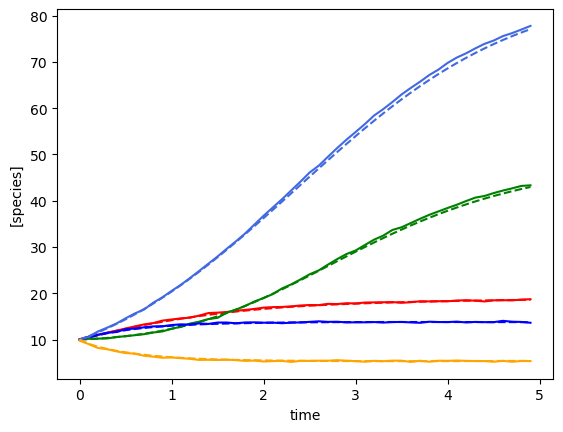

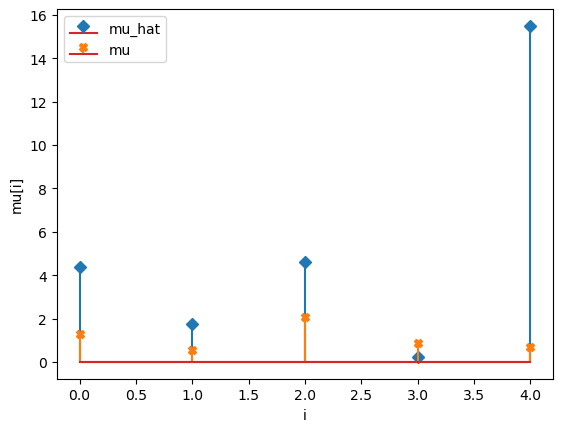

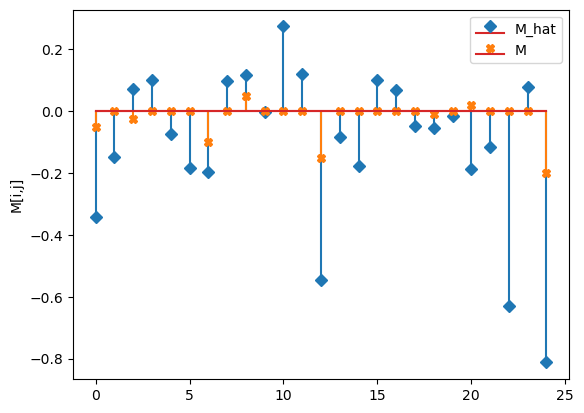

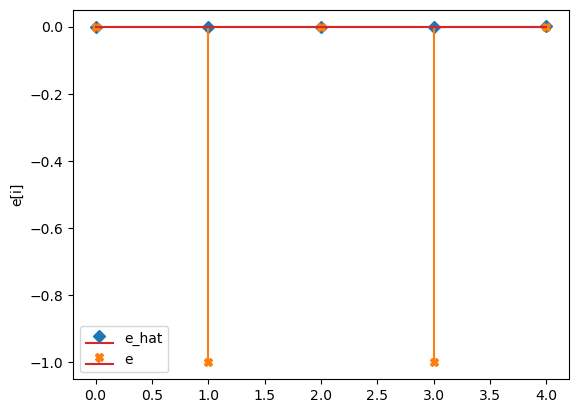

In [5]:
# get the best lambda/alpha values on a grid via cross validation
a0, a1, a2 = fit_alpha_Ridge2(
    X, F, num_species=num_species, num_pert=1, n_a0=10, n_a1=10, n_a2=10)

# do final fit
mu_h, M_h, e_h = do_final_fit_Ridge2(
    X, F, num_species=num_species, num_pert=1, a0=a0, a1=a1, a2=a2)

predictor = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     epsilon=e_h,
                     num_perturbations=num_perturbations)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times,
                                                sy0=np.hstack(
                                                    (init_species, init_metabolites)))

# PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h), e=(np.array([0, -1, 0, -1, 0]), e_h))

### Fit same data with the multi-penalty lasso

minimum found: a/error: [1.29154967e-03 4.64158883e-06] 0.10682452148954365
mu_hat/mu:
[ 2.03866736  0.56491041  4.38576018  0.87465559 11.68823861]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.12 -0.03  0.    0.02 -0.03]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.09  0.02 -0.37 -0.02 -0.1 ]
 [ 0.    0.    0.   -0.01 -0.  ]
 [-0.03 -0.03 -0.56  0.02 -0.69]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 0, 'num_perturbations': 0, 'mu': [2.0386673618506133, 0.5649104095123424, 4.385760176737035, 0.8746555945760397, 11.688238606204923], 'M': [[-0.11928302492644625, -0.030518067598021895, 0.0, 0.02154189416446347, -0.028507713603485904], [0.0, -0.09954284720973505, 0.0, 0.049488846255163824, 0.0], [0.08733196200158526, 0.01883921728503

AttributeError: 'int' object has no attribute 'shape'

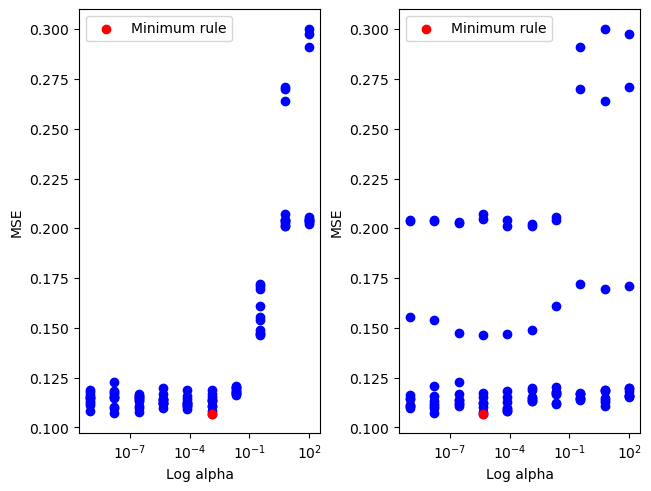

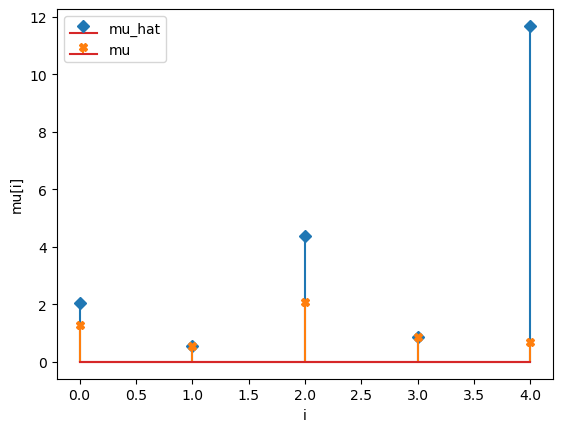

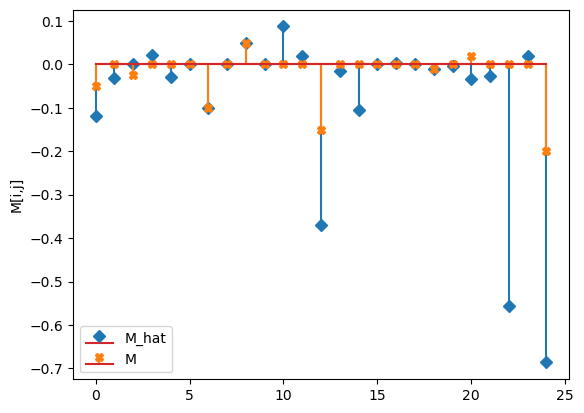

In [8]:
# F = dlnX/dt
DlnX = np.diff(np.log(yobs), axis=0)
Dt = np.tile(np.diff(times), (num_species, 1))
F = np.divide(DlnX, np.transpose(Dt))

# X matrix: stacked observed counts
mX = np.vstack([np.transpose(yobs), np.ones(len(times))])
tX = np.transpose(mX[:, :-1])

alphas = fit_alpha_MPLasso(tX, F, 10)

alpha = np.append(np.ones(num_species)*alphas[0], alphas[1])
model = MultiPenaltyLasso(alpha=alpha)
model.fit(tX, F)

mu_h = [model.coef_[i][-1] for i in range(0, num_species)]
M_h = [model.coef_[i][:num_species].tolist() for i in range(0, num_species)]

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

rho = 100

# get prediction
predictor = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     beta=rho)  # FIXME: what is rho on how to solve for this problem?
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(
    times=times, sy0=np.hstack((init_species, init_metabolites)))

# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, sobs, sobs_h, times)